# Multi-objective optimization

When there are multiple objective functions ($p$) to be optimized, multi-objective optimization is used.  
Note that in this tutorial, "solution" means the pair of objective functions $y = (y_1(x), y_2(x), \dots, y_p(x))$.  
Define the solution size relation $\prec$ as follows.  

$y \prec y^{'}\Longleftrightarrow \forall \ i \le p, y_i \le y^{'}_i  \land \exists \ j \le p, y_j < y^{'}_j$ 

A **Pareto solution** (in the maximization problem) is one in which no solution is larger than itself satisfying the above relations.  
In other words, if you try to improve the value of any objective function, one of the other objective functions will deteriorate.  
When there is a trade-off between objective functions, there are multiple Pareto solutions, and the numerical task is to find them efficiently.

PHYSBO implements a Bayesian optimization method to find Pareto solutions efficiently.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import physbo
%matplotlib inline

## Test functions

In this tutorial, we will use VLMOP2, which is a benchmark function for multi-objective optimization.  
The number of objective functions is two.

$$
\begin{split}
    y_1(\vec{x}) &= 1 - \exp\left[-\sum_{i=1}^N\left( x_i - 1/\sqrt{N}\right)^2\right] \\
    y_2(\vec{x}) &= 1 - \exp\left[-\sum_{i=1}^N\left( x_i + 1/\sqrt{N}\right)^2\right],
\end{split}
$$

where $y_1$ and $y_2$ have minimums at $x_1 = x_2 = \cdots x_N = 1/\sqrt{N}$ and $x_1 = x_2 = \cdots x_N = -1/\sqrt{N}$, respectively, both of which are 0. Also, the upper bound is 1.

Since PHYSBO solves a maximization problem, the objective function is again multiplied by -1.

- Refernce
    - Van Veldhuizen, David A. Multiobjective evolutionary algorithms: classifications, analyses, and new innovations. No. AFIT/DS/ENG/99-01. AIR FORCE INST OF TECH WRIGHT-PATTERSONAFB OH SCHOOL OF ENGINEERING, 1999.

In [2]:
def vlmop2_minus(x):
    n = x.shape[1]
    y1 = 1 - np.exp(-1 * np.sum((x - 1/np.sqrt(n)) ** 2, axis = 1))
    y2 = 1 - np.exp(-1 * np.sum((x + 1/np.sqrt(n)) ** 2, axis = 1))

    return np.c_[-y1, -y2]

## Preparation of search candidate data

Let the input space $\vec{x}$ be two-dimensional, and generate a grid of candidate points on [-2, 2] × [-2, 2].

In [3]:
import itertools
a = np.linspace(-2,2,101)
test_X = np.array(list(itertools.product(a, a)))

In [4]:
test_X

array([[-2.  , -2.  ],
       [-2.  , -1.96],
       [-2.  , -1.92],
       ...,
       [ 2.  ,  1.92],
       [ 2.  ,  1.96],
       [ 2.  ,  2.  ]])

In [5]:
test_X.shape

(10201, 2)

## Definition of simulator

In [6]:
class simulator(object):
    def __init__(self, X):
        self.t = vlmop2_minus(X)
    
    def __call__( self, action):
        return self.t[action]

In [7]:
simu = simulator(test_X)

## Plotting the functions

Let's plot each of the two objective functions.  The first objective function has a peak in the upper right corner, and the second objective function has a trade-off with a peak in the lower left corner (The star is the position of the peak.).

### First objective function

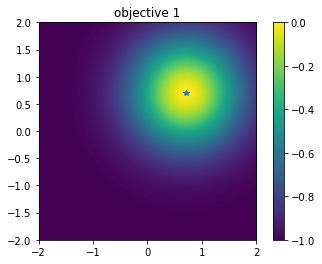

In [8]:
plt.figure()
plt.imshow(simu.t[:,0].reshape((101,101)), vmin=-1.0, vmax=0.0, origin="lower", extent=[-2.0, 2.0, -2.0, 2.0])
plt.title("objective 1")
plt.colorbar()
plt.plot([1.0/np.sqrt(2.0)], [1.0/np.sqrt(2.0)], '*')
plt.show()

### Second objective function

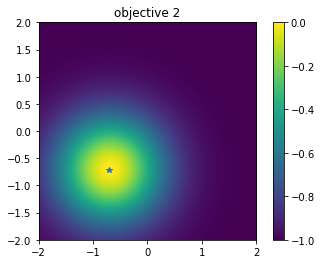

In [9]:
# plot objective 2
plt.figure()
plt.imshow(simu.t[:,1].reshape((101,101)), vmin=-1.0, vmax=0.0, origin="lower", extent=[-2.0, 2.0, -2.0, 2.0])
plt.title("objective 2")
plt.colorbar()
plt.plot([-1.0/np.sqrt(2.0)], [-1.0/np.sqrt(2.0)], '*')
plt.show()

## Performing optimizations.

## Setting policy

Use `physbo.search.discrete_multi.policy` for multi-objective optimization.  
Specify the number of objective functions in `num_objectives`.

In [10]:
policy = physbo.search.discrete_multi.policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

As with the usual usage of `physbo.search.discrete.policy` (with one objective function), optimization is done by calling the `random_search` or `bayes_search` methods.  The basic API and usage are roughly the same as `discrete.policy`.

### Random search

In [ ]:
policy = physbo.search.discrete_multi.policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

res_random = policy.random_search(max_num_probes=50, simulator=simu)

The evaluation value of the objective function (the array) and the action ID at that time are displayed.  
It also displays a message when the Pareto set is updated.

If you want to display the contents of the Pareto set when it is updated, specify `disp_pareto_set=True`.  
Pareto set is sorted in ascending order of the first objective function value. 

In [ ]:
policy = physbo.search.discrete_multi.policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)
res_random = policy.random_search(max_num_probes=50, simulator=simu, disp_pareto_set=True)

### Checking results

 #### History of evaluation values

In [ ]:
res_random.fx[0:res_random.num_runs]

#### Obtaining the Pareto solution

In [14]:
front, front_num = res_random.export_pareto_front()
front, front_num

(array([[-0.95713719, -0.09067194],
        [-0.92633083, -0.29208351],
        [-0.63329589, -0.63329589],
        [-0.52191048, -0.72845916],
        [-0.26132949, -0.87913689],
        [-0.17190645, -0.91382463]]),
 array([40,  3, 19, 16, 29, 41]))

#### Plotting the solution (evaluated value)

Note again that the space to be plotted is $y = (y_1, y_2)$ and not $x = (x_1, x_2)$.

The red plot is the Pareto solution.

In [15]:
def plot_pareto_front(res):
    front, front_num = res.export_pareto_front()
    dominated = [i for i in range(res.num_runs) if i not in front_num]
    points = res.fx[dominated, :]

    plt.figure(figsize=(7, 7))
    plt.scatter(res.fx[dominated,0], res.fx[dominated,1], c = "blue")
    plt.scatter(front[:, 0], front[:, 1], c = "red")
    plt.title('Pareto front')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.xlim([-1.0,0.0])
    plt.ylim([-1.0,0.0])

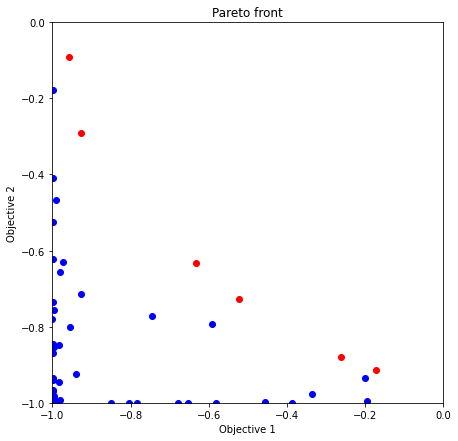

In [16]:
plot_pareto_front(res_random)

#### Calculate the volume of the dominated region

A solution that is not a Pareto solution, i.e., a solution $y$ for which there exists a solution $y'$ that is better than itself, is called a inferior solution ($\exists y' y\prec y'$).  The volume of the inferior solution region, which is the space occupied by inferior solutions in the solution space (a subspace of the solution space), is one of the indicators of the results of multi-objective optimization.  The larger this value is, the more good Pareto solutions are obtained.`res_random.pareto.volume_in_dominance(ref_min, ref_max)` calculates the volume of the inferior solution region in the hyper-rectangle specified by `ref_min` and `ref_max`.

In [17]:
res_random.pareto.volume_in_dominance([-1,-1],[0,0])

0.2376881844865093

## Bayesian optimization

For `bayes_search` in the multi-objective case, `score` can be selected from the following method

- HVPI (HyperVolume-based Probability of Improvement)
- EHVI (Expected Hyper-Volume Improvement)
- TS (Thompson Sampling)

The following 50 evaluations (10 random searches + 40 Bayesian optimizations) will be performed with different scores.

### HVPI (HyperVolume-based Probability of Improvement)

The improvement probability of a non-dominated region in a multi-dimensional objective function space is obtained as a score.  

- Reference
    - Couckuyt, Ivo, Dirk Deschrijver, and Tom Dhaene. "Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization." Journal of Global Optimization 60.3 (2014): 575-594.

In [ ]:
policy = physbo.search.discrete_multi.policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_HVPI = policy.bayes_search(max_num_probes=40, simulator=simu, score='HVPI', interval=10)

#### Plotting the Pareto solution

We can see that more Pareto solutions are obtained compared to random sampling.

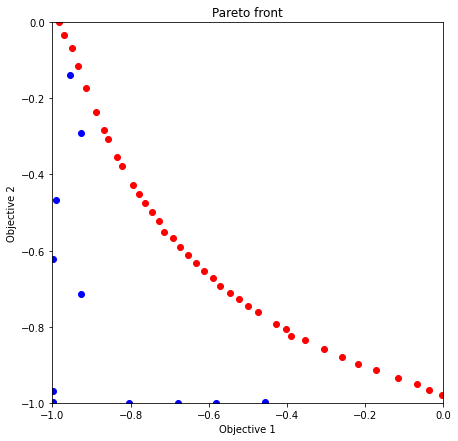

In [19]:
plot_pareto_front(res_HVPI)

#### Volume of dominated region

In [20]:
res_HVPI.pareto.volume_in_dominance([-1,-1],[0,0])

0.32877907991633726

### EHVI (Expected Hyper-Volume Improvement)

The expected improvement of the non-dominated region in the multi-dimensional objective function space is obtained as score.  

- Reference
    - Couckuyt, Ivo, Dirk Deschrijver, and Tom Dhaene. "Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization." Journal of Global Optimization 60.3 (2014): 575-594.

In [ ]:
policy = physbo.search.discrete_multi.policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_EHVI = policy.bayes_search(max_num_probes=40, simulator=simu, score='EHVI', interval=10)

#### Plotting the Pareto solution

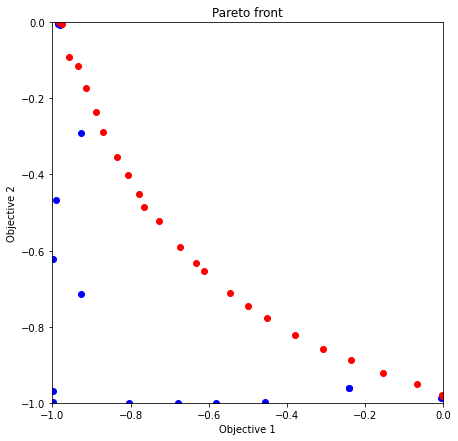

In [22]:
plot_pareto_front(res_EHVI)

#### Volume of dominated region

In [23]:
res_EHVI.pareto.volume_in_dominance([-1,-1],[0,0])

0.3200467412741881

### TS (Thompson Sampling)

In Thompson Sampling for the single objective case, at each candidate (test_X), sampling is performed from the posterior distribution of the objective function, and the candidate with the largest value is recommended as the next search point. In the multi-objective case, one candidate is randomly selected as the next search point from among the candidates with the maximum value based on the Pareto rule for the sampled values, i.e., the Pareto-optimal candidates.

- Reference
    - Yahyaa, Saba Q., and Bernard Manderick. "Thompson sampling for multi-objective multi-armed bandits problem." Proc. Eur. Symp. Artif. Neural Netw., Comput. Intell. Mach. Learn.. 2015.

In [ ]:
policy = physbo.search.discrete_multi.policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_TS = policy.bayes_search(max_num_probes=40, simulator=simu, score='TS', interval=10, num_rand_basis=5000)

#### Plotting the Pareto solution

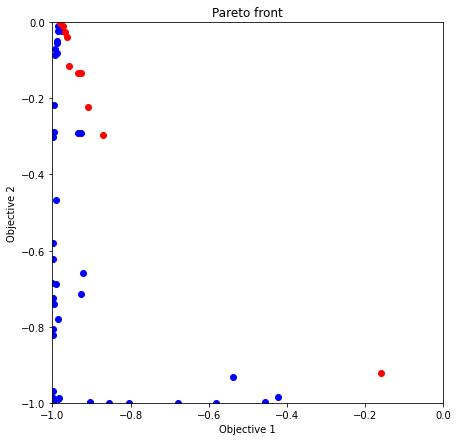

In [25]:
plot_pareto_front(res_TS)

#### Volume of dominated region

In [26]:
res_TS.pareto.volume_in_dominance([-1,-1],[0,0])

0.16415446221006114

## Appendix: Full search

In `random_search`, you can easily do a full search by passing the number of all data (`N = test_X.shape[0]`) to `max_num_probes`.  
Since it takes time to evaluate all data, reduce the number of data in advance.

In [ ]:
test_X_sparse = np.array(list(itertools.product(np.linspace(-2, 2, 21), repeat=2)))
simu_sparse = simulator(test_X_sparse)

policy = physbo.search.discrete_multi.policy(test_X=test_X_sparse, num_objectives=2)
policy.set_seed(0)

N = test_X_sparse.shape[0]
res_all = policy.random_search(max_num_probes=N, simulator=simu_sparse)

#### Plotting the Pareto solution

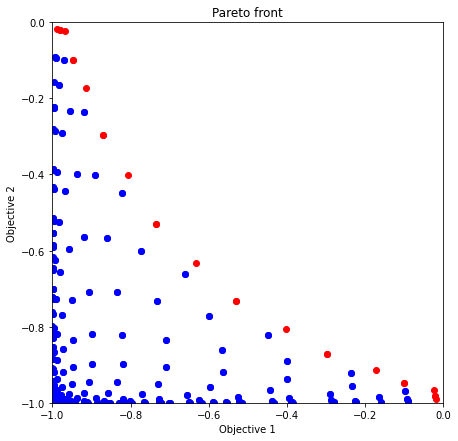

In [28]:
plot_pareto_front(res_all)

#### Volume of dominated region

In [29]:
res_all.pareto.volume_in_dominance([-1,-1],[0,0])

0.30051687493437484